In [2]:

import os 

In [ ]:
def fasta_dict(infile):
    seqs = {}
    with open(infile, 'r') as file:
        seq_id = None
        seq_lines = []
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if seq_id is not None:
                    seqs[seq_id] = ''.join(seq_lines)
                seq_id = line[1:].split()[0] 
                seq_lines = []
            else:
                seq_lines.append(line)
        if seq_id is not None:
            seqs[seq_id] = ''.join(seq_lines)
    return seqs
def remove_gap_columns(sequences):
    seq_ids = list(sequences.keys())
    lengths = [len(sequences[seq_id]) for seq_id in seq_ids]
    max_len = max(lengths)
    
    for seq_id in seq_ids:
        seq = sequences[seq_id]
        if len(seq) < max_len:
            sequences[seq_id] = seq + '-' * (max_len - len(seq))
    
    columns_to_keep = []
    for i in range(max_len):
        if all(sequences[seq_id][i] != '-' for seq_id in seq_ids):
            columns_to_keep.append(i)
    
    cleaned_seqs = {}
    for seq_id in seq_ids:
        cleaned_seq = ''.join(sequences[seq_id][i] for i in columns_to_keep)
        cleaned_seqs[seq_id] = cleaned_seq
    return cleaned_seqs

def write_fasta(seq_dict, outfile):
    with open(outfile, 'w') as f:
        for sp, seq in seq_dict.items():
            f.write(f">{sp}\n")
            for i in range(0, len(seq), 60):  # 60 characters limit. 
                f.write(seq[i:i+60] + '\n')
                
def fasta_to_phylip(fasta_file, phylip_file):
    def read_fasta(file):
        sequences = {}
        with open(file, 'r') as f:
            seq_id = None
            seq_lines = []
            for line in f:
                line = line.strip()
                if line.startswith(">"):
                    if seq_id:
                        sequences[seq_id] = ''.join(seq_lines) # check again later
                    seq_id = line[1:].split()[0]
                    seq_lines = []
                else:
                    seq_lines.append(line)
            if seq_id:
                sequences[seq_id] = ''.join(seq_lines)
        return sequences

    sequences = read_fasta(fasta_file)
    ids = list(sequences.keys())
    seqs = list(sequences.values())

    with open(phylip_file, 'w') as out:
        out.write(f"{len(seqs)} {seq_length}\n")
        for id_, seq in zip(ids, seqs):
            name = id_[:4].ljust(10)  
            out.write(f"{name}{seq}\n")


# 3 Cleaning up the data

In [5]:
indir = r"D:\IMSc coursework\SequenceAnalysis\SequenceAnalysis-Course\HW-3\yeast_orthologues_aligned"
allseqs = {}
for file in os.listdir(indir):
    geneseqs = fasta_dict(os.path.join(indir,file))
    cleanseq = remove_gap_columns(geneseqs)
    allseqs[file] = cleanseq
    
genes = list(allseqs.keys())
species = list(allseqs['YAL008W_aligned.fasta'].keys())
allspecies_seq = {sp: '' for sp in species}

for gene in genes:
    gene_data = allseqs[gene]
    prefix_map = {sp[:3]: sp for sp in gene_data.keys()} 
    for sp in species:
        prefix = sp[:3]
        if prefix in prefix_map:
            matched_sp = prefix_map[prefix]
            allspecies_seq[sp] += gene_data[matched_sp]
            
write_fasta(allspecies_seq, 'species_aligned.fasta')



In [10]:
fasta_to_phylip('species_aligned.fasta', 'species_aligned.phy')

# 3b. UPGMA


In [ ]:
%run UPGMA_utils.py
from Bio.Phylo.TreeConstruction import DistanceCalculator 
from Bio import AlignIO


species_aligned = AlignIO.read(open('species_aligned.phy'), 'phylip')
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(species_aligned)
label_dict = {label: i for i, label in enumerate(dm.names)}
print(label_dict)

{'Scas': 0, 'Sjap': 1, 'Spom': 2, 'Klac': 3, 'Ctro': 4, 'Cdub': 5, 'Ncra': 6, 'Clus': 7, 'Agos': 8, 'Cpar': 9, 'Cgui': 10, 'Anid': 11, 'Dhan': 12, 'Ylip': 13, 'Cgla': 14, 'Calb': 15, 'Soct': 16, 'Scer': 17}


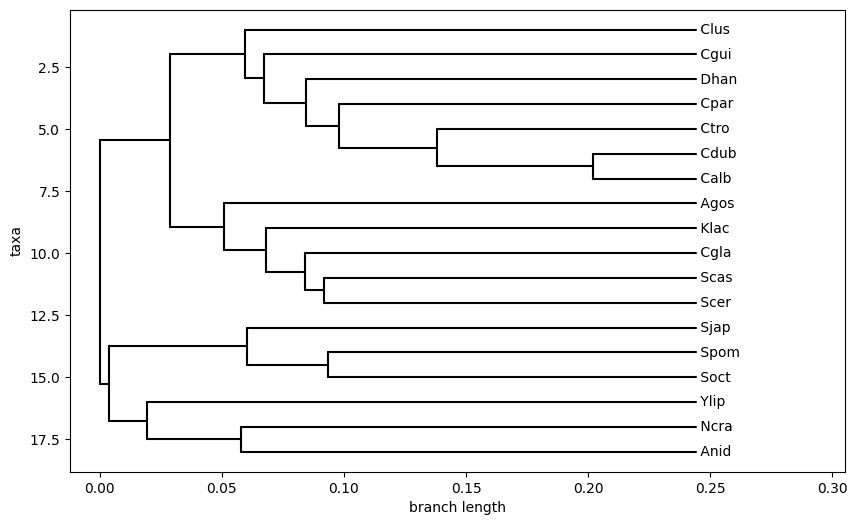

In [8]:

from Bio import Phylo
from io import StringIO
import matplotlib.pyplot as plt

tree = upgma(dm, label_dict)
newick_str = tree_to_newick(tree)
handle = StringIO(newick_str)
phylo_tree = Phylo.read(handle, "newick")
newick_str = tree_to_newick(tree)
handle = StringIO(newick_str)
phylo_tree = Phylo.read(handle, "newick")


fig = plt.figure(figsize=(10, 6))  
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(phylo_tree, do_show=False, axes=ax)

plt.savefig("upgma_tree.png", dpi=300, bbox_inches="tight")
# plt.close()
